<a target="_blank" href="https://colab.research.google.com/github/lm2612/Tutorials/blob/main/4_computervision/4-ComputerVision_Classification.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Convolutional Neural Network Classifier

Today we will build convolutional neural network to classify pets using the [Oxford pet dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) which consists of thousands of photos of cats and dogs.

Import packages and load the dataset. We have chosen this dataset as it was one of torchvision's built-in datasets available from [https://pytorch.org/vision/main/datasets.html](https://pytorch.org/vision/main/datasets.html)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, ToPILImage, Compose, CenterCrop, Resize
import matplotlib.pyplot as plt

np.random.seed(0)
torch.manual_seed(0)

# Transforms
img_to_tensor = ToTensor()
tensor_to_img = ToPILImage()
crop = CenterCrop(360)        # crop all images to same size (360 x 360)
resize = Resize(128)          # resize so images are smaller / computationally cheaper

# the Oxford pet dataset is labelled by 37 breeds of cats and dogs, but we
# will use the dataset to predict species cat (0) or dog (1)
# manually define transform to convert breed id (1-37) to species id (0/1)
cat_breed_ids = [0, 5, 6, 7, 9, 11, 20, 23, 26, 27, 32, 33]

def breed2species(breedid):
    if breedid in cat_breed_ids:
        return 0
    else:
        return 1

data = datasets.OxfordIIITPet(
    root="./",
    download=True,
    target_types = "category",
    transform=Compose([img_to_tensor, crop, resize]),
    target_transform=breed2species
)

100%|██████████| 792M/792M [00:07<00:00, 99.3MB/s]
100%|██████████| 19.2M/19.2M [00:00<00:00, 107MB/s] 


## Set up
First, use `torch.utils.data.random_split` to split the data into 80% training, 10% training and 10% validation.

In [3]:
training_data, validation_data, test_data = torch.utils.data.random_split(data, lengths=[0.8, 0.1, 0.1])

Check the shape of the images and what they look like: Use the transform `tensor_to_img()` to quickly plot images.

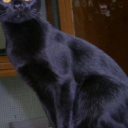

In [24]:
X, y = training_data[0]
tensor_to_img(X)

In [11]:
X.shape

torch.Size([3, 128, 128])

## Create our dataloaders
Set up a dataloader for the training data with a batch size of 128 and a validation data with a batch size of 64.

In [12]:
dataloader = torch.utils.data.DataLoader(training_data,
                                         shuffle=True,
                                         batch_size=128)
dataloader_validation = torch.utils.data.DataLoader(validation_data,
                                         shuffle=True,
                                         batch_size=64)

In [13]:
len(training_data), len(validation_data)

(2944, 368)

In [16]:
# Get a test batch ready for testing the network layers
X_batch, y_batch = next(iter(dataloader))

# Check the shapes of X_batch, y_batch
X_batch.shape, y_batch.shape

# I guess it's batch size of 128 instances of 3 channels (RGB), 128x128 resolution? then y is 128x1 vector (just 1 or 0; dog or cat)

(torch.Size([128, 3, 128, 128]), torch.Size([128]))

## Test network layers
We will create a convolutional network with 3 layers. First, explore what the convolutions are doing.

Here is our first convolutional layer, that includes our convolution, RELU, BatchNorm and Pooling. Read the docs on [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) and consider the choices for the arguments. `in_channels`, `out_channels`, and `kernel_size` are always needed, but you can also define `stride` and `padding`. Try some different choices and compare what the output shape is like.

In [19]:
conv_layer_1 = torch.nn.Sequential(
      torch.nn.Conv2d(in_channels=3, #RGB
                      out_channels=3, # still RGB
                      kernel_size=3, # depends on the smoothing effect desired
                      padding=0), # defautls to zero; padding added all around 4 sides
      torch.nn.ReLU(),
      torch.nn.BatchNorm2d(3),
      torch.nn.MaxPool2d(2))

Test the first convolutional layer on X_batch. What shape is it? Plot it using `tensor_to_img()`.

X_batch.shape: torch.Size([128, 3, 128, 128])
conv_layer_1(X_batch).shape: torch.Size([128, 3, 63, 63])
note difference in sizes


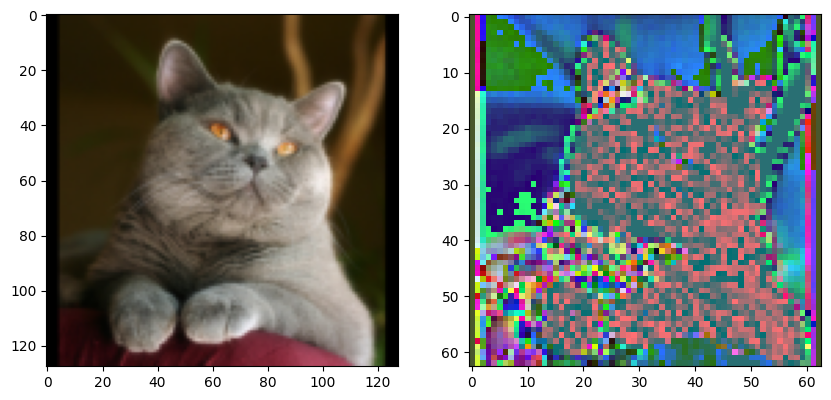

In [39]:
# Check shape of X_batch before and after applying conv_layer_1. Remember shape=(BATCH, CHANNELS, WIDTH, HEIGHT)
print('X_batch.shape:', X_batch.shape)

print('conv_layer_1(X_batch).shape:', conv_layer_1(X_batch).shape)

# reduces from 128x3x128x128 to 128x3x63x63

# Plot
# tensor_to_img(conv_layer_1(X_batch)[0])
# tensor_to_img((X_batch)[0])
# show both of these images side by side
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(tensor_to_img(X_batch[0]))
plt.subplot(1,2,2)
plt.imshow(tensor_to_img(conv_layer_1(X_batch)[0]))
print('note difference in sizes')

In [31]:
X_batch[0].shape

torch.Size([3, 128, 128])

Notice the size of our tensor has changed: its smaller because of the convolution and pooling. We can see some features from the convolution, that highlight regions of the image where the gradient is quickly changing, which shows us outlines of objects in the image. For the second convolutional layer, we will use the same structure.

In [40]:
conv_layer_2 = torch.nn.Sequential(
      torch.nn.Conv2d(in_channels = 3,
                      out_channels = 3,
                      kernel_size = 3,
                      padding=0),
      torch.nn.ReLU(),
      torch.nn.BatchNorm2d(num_features = 3),
      torch.nn.MaxPool2d(kernel_size = 2))

Test this layer on the output of your previous layer. What shape is it?

In [42]:
print('Shape before unsqueeze:', conv_layer_1(X_batch)[0].shape)

# Add a batch dimension to the single image tensor before passing it to conv_layer_2
output_from_conv2 = conv_layer_2(conv_layer_1(X_batch)[0].unsqueeze(0))

print('Shape after conv_layer_2 (with batch dim):', output_from_conv2.shape)

# Remove the batch dimension before converting to image for plotting
tensor_to_img(output_from_conv2[0])

Shape before unsqueeze: torch.Size([3, 63, 63])
Shape after conv_layer_2 (with batch dim): torch.Size([1, 3, 30, 30])


In [43]:
conv_layer_3 = torch.nn.Sequential(
      torch.nn.Conv2d(in_channels = 3,
                      out_channels = 3,
                      kernel_size = 3,
                      padding=0),
      torch.nn.ReLU(),
      torch.nn.BatchNorm2d(num_features = 3),
      torch.nn.MaxPool2d(kernel_size = 2))

Again, test this layer on the output of your previous layer. What shape is it?

In [45]:
# Get the 3D output from conv_layer_1 for a single image
output_from_conv1_single_image = conv_layer_1(X_batch)[0]
print('Shape of single image output from conv_layer_1 (3D input to conv_layer_2):', output_from_conv1_single_image.shape) # This is (3, 63, 63)

# Pass this 3D image with an added batch dimension to conv_layer_2
output_from_conv2_single_batch = conv_layer_2(output_from_conv1_single_image.unsqueeze(0))
print('Shape after conv_layer_2 (with batch dim):', output_from_conv2_single_batch.shape) # This is (1, 3, 30, 30)

# Pass this 4D output to conv_layer_3
output_from_conv3_single_batch = conv_layer_3(output_from_conv2_single_batch)
print('Shape after conv_layer_3 (with batch dim):', output_from_conv3_single_batch.shape) # This will be (1, 3, 14, 14) given kernel_size=3, MaxPool2d(2)

# Remove the batch dimension before converting to image for plotting
tensor_to_img(output_from_conv3_single_batch[0])

Shape of single image output from conv_layer_1 (3D input to conv_layer_2): torch.Size([3, 63, 63])
Shape after conv_layer_2 (with batch dim): torch.Size([1, 3, 30, 30])
Shape after conv_layer_3 (with batch dim): torch.Size([1, 3, 14, 14])


Lastly, we will pass our tensor through a fully connected linear layer to get our output. Use the shape of the previous layer to deduce the number of features going into the linear layer. The size should be `NUM_CHANNELS * NUM_WIDTH * NUM_HEIGHT`.

In [46]:
classifier = torch.nn.Sequential(
      torch.nn.Flatten(),
      torch.nn.Linear(in_features= 3*30*30, # 3 channels, 30x30 image?
                      out_features=1),
      torch.nn.Sigmoid())

## Create model
Create a convolutional neural network classifier. As before, it needs to be a `torch.nn.Module` and have the method `forward`. Use the conv layers we have created above, but put them into the class below. Set up the forward module

In [49]:
class ConvNet(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # Create CNN in layers
        # first conv layer
        self.conv_layer_1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3,
                            out_channels=3,
                            kernel_size=3),
            torch.nn.ReLU(),
            # torch.nn.BatchNorm2d(3),  # the lecture notes didn't include batch normalization
            torch.nn.MaxPool2d(kernel_size=2)) # halves the width and length each time

        # second conv layer
        self.conv_layer_2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3,
                            out_channels=3,
                            kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2))

        # third conv layer
        self.conv_layer_3 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3,
                            out_channels=3,
                            kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2))

        # classifier
        self.classifier = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(in_features=3*14*14,
                            out_features=1),
            torch.nn.Sigmoid())

    def forward(self, x):
        # first layer
        x = self.conv_layer_1(x)
        # second layer
        x = self.conv_layer_2(x)
        # third layer
        x = self.conv_layer_3(x)
        # classifier
        x = self.classifier(x)

        return x


Create an instance of ConvNet and test it on your first batch,

In [50]:
# Create an instance of ConvNet
my_cnn =  ConvNet()

# Apply to first batch
my_cnn(X_batch)


pred_batch = my_cnn(X_batch)
print(pred_batch.shape)


torch.Size([128, 1])


## Set up loss function and optimiser
Decide on a suitable loss function for a classifier.

We will use Binary Cross Entropy (BCE). Test your loss function with the output of your network.

In [51]:
loss = torch.nn.BCELoss()
loss(pred_batch, y_batch.float().unsqueeze(1))


tensor(0.6929, grad_fn=<BinaryCrossEntropyBackward0>)

And we also need to set up our optimiser and provide our network parameters. Use the [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) optimiser.

In [53]:
optimiser = torch.optim.Adam(my_cnn.parameters(), lr=0.001)


## Training loop
Start the training loop - it will look similar to our training loop from this morning. You can expect it to take several minutes to run - that's why its always sensible to check you can run a smaller version of it first with a subset of the data.

In [ ]:
## Plot the training and validation losses on a logscale.




In [55]:
### from gemini:
training_epoch_losses = [] # This list will now store the mean loss for each epoch
validation_epoch_losses = [] # This list will now store the mean loss for each epoch
num_epochs = 10

for epoch in range(num_epochs):
    # Training loop
    current_epoch_batch_training_losses = [] # Temporary list to store batch losses for the current epoch
    my_cnn.train() # Set model to training mode
    for X_batch, y_batch in dataloader:
        # Zero the gradients
        optimiser.zero_grad()
        # predict
        pred_batch = my_cnn(X_batch)
        # compute loss
        loss_value = loss(pred_batch, y_batch.float().unsqueeze(1))
        # gradient
        loss_value.backward()
        # update
        optimiser.step()

        current_epoch_batch_training_losses.append(loss_value.item()) # add batch losses to temp list

    # Calculate mean training loss for the current epoch
    mean_training_loss_this_epoch = sum(current_epoch_batch_training_losses) / len(current_epoch_batch_training_losses)
    training_epoch_losses.append(mean_training_loss_this_epoch) # Store mean epoch loss


    # Validation loop
    current_epoch_batch_validation_losses = [] # Temporary list to store batch losses for the current epoch
    my_cnn.eval() # Set model to evaluation mode
    with torch.no_grad(): # Disable gradient calculation for validation
        for X_batch, y_batch in dataloader_validation:
            pred_batch = my_cnn(X_batch)
            loss_value = loss(pred_batch, y_batch.float().unsqueeze(1))
            current_epoch_batch_validation_losses.append(loss_value.item()) # add batch losses to temp list
    my_cnn.train() # Set model back to training mode for next epoch

    # Calculate mean validation loss for the current epoch
    mean_validation_loss_this_epoch = sum(current_epoch_batch_validation_losses) / len(current_epoch_batch_validation_losses)
    validation_epoch_losses.append(mean_validation_loss_this_epoch) # Store mean epoch loss


    # After every epoch print mean losses
    print(f"After epoch {epoch}: Training loss={mean_training_loss_this_epoch:.2f}, validation loss={mean_validation_loss_this_epoch:.2f}")

After epoch 0: Training loss=0.69, validation loss=0.69
After epoch 1: Training loss=0.68, validation loss=0.68
After epoch 2: Training loss=0.68, validation loss=0.68
After epoch 3: Training loss=0.68, validation loss=0.67
After epoch 4: Training loss=0.67, validation loss=0.67
After epoch 5: Training loss=0.67, validation loss=0.67
After epoch 6: Training loss=0.67, validation loss=0.67
After epoch 7: Training loss=0.67, validation loss=0.66
After epoch 8: Training loss=0.66, validation loss=0.66
After epoch 9: Training loss=0.66, validation loss=0.66


## Results

Write a function to convert the continuous output to zero or one so you can check if the prediction is correct.

In [78]:
# convert continuous output to zero or one
def continuous_to_binary(x):
    # This function expects a single scalar probability
    return 1 if x >= 0.50 else 0
    # ^ something wrong; switching to 0.55 causes all gueses to flip from dog to cat

Plot a few images from the validation dataset and set the title of each image to show if the network predicted "dog" or "cat"

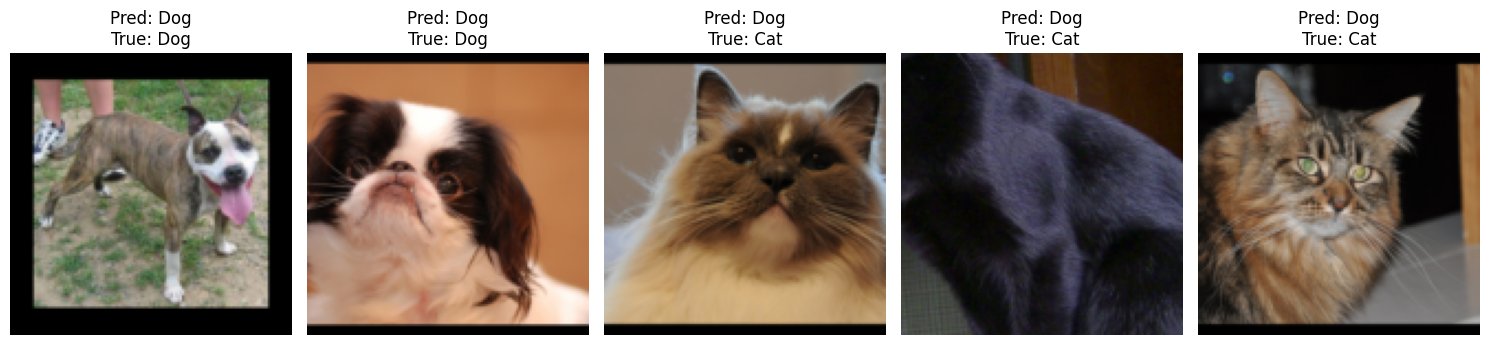

In [79]:
# Plot a few images from the validation dataset and set the title of each image to show if the network predicted "dog" or "cat"

plt.figure(figsize=(15, 5))
class_names = ['Cat', 'Dog'] # Assuming 0 for Cat, 1 for Dog

# Get a batch of validation data
for i in range(5): # Plot 5 images
    X_single, y_single = validation_data[i] # Get a single image and label from the validation dataset

    # Add a batch dimension (required for model input)
    X_batch_single = X_single.unsqueeze(0)

    # Make prediction
    my_cnn.eval() # Set model to evaluation mode
    with torch.no_grad(): # Disable gradient calculation
        pred_prob = my_cnn(X_batch_single).item() # Get the single probability output
    my_cnn.train() # Set model back to training mode

    # Convert probability to binary prediction
    predicted_class = continuous_to_binary(pred_prob)

    # Plotting
    plt.subplot(1, 5, i + 1)
    plt.imshow(tensor_to_img(X_single))
    plt.title(f"Pred: {class_names[predicted_class]}\nTrue: {class_names[y_single]}") # Removed .item() from y_single
    plt.axis('off')

plt.tight_layout()
plt.show()

In [85]:
# print all predictions and true values
for i in range(len(validation_data)):
    X_single, y_single = validation_data[i]
    X_batch_single = X_single.unsqueeze(0)
    my_cnn.eval()
    with torch.no_grad():
        pred_prob = my_cnn(X_batch_single).item()
    my_cnn.train()
    predicted_class = continuous_to_binary(pred_prob)
    # print(predicted_class)


In [87]:
# print probability/confidence in dog for each validation photo
for i in range(len(validation_data)):
    X_single, y_single = validation_data[i]
    X_batch_single = X_single.unsqueeze(0)
    my_cnn.eval()
    with torch.no_grad():
        pred_prob = my_cnn(X_batch_single).item()
    my_cnn.train()
    predicted_class = continuous_to_binary(pred_prob)
    # print(pred_prob) # getting this value every time 0.5562373995780945


Let's plot the training and validation losses to visualize the learning progress.

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(training_epoch_losses, label='Training Loss')
plt.plot(validation_epoch_losses, label='Validation Loss')
plt.yscale('log') # Use a log scale as requested earlier, helpful for loss plots
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.legend()
plt.grid(True)
plt.show()

Congratulations! You've built your own cat/dog classifier. Now try and improve upon it with more data, a deeper or wider network, or with data augmentation. You could also try and predict the breed.

### Check convolutional layers

We discussed in class that convolutions act to either highlight or blur gradients in images, which help identify the shapes and edges of different objects. In general, the first few layers identify basic features within images and deeper layers identify more complex features (they also become more abstract and difficult to interpret!). We can try to investigate what our neural network has learned by looking at what each convolutional layer does after training. What are the convolutional layers doing after training?


In [ ]:
X_batch, y_batch = next(iter(dataloader_validation))

fig, axs = plt.subplots(2, 2, figsize=(8, 6))
axs = axs.flatten()
axs[0].imshow(tensor_to_img(X_batch[0]))

# Layer 1:
X_conv = my_network.conv_layer_1(X_batch)
# Plot on axs[1]
axs[1].imshow(tensor_to_img(X_conv[0]))

# Layer 2:

# Plot on axs[2]


# Layer 3

# Plot on axs[3]

## Test dataset
Finally, apply on the test data set and calculate the number of true positives, false positives, true negatives and false negatives.


In [ ]:
dataloader_test = torch.utils.data.DataLoader(test_data,
                                         shuffle=True,
                                         batch_size=64)
